# Optimizing the $\ell_1$ norm with SuperPolyak optimizer class

In this cell, we use the SuperPolyak optimizer class to optimize the l1 norm:
$$
f(x) = \|x\|_1.
$$

In [ ]:
# A pytorch compatible version of the above code.
import AlternatingProjections
import util
import numpy as np
import torch
import SuperPolyak

# Problem dimension
d = 10
# Number of Equations:
max_elts = d  # try 1, 2, 3, d.
# The superlinear contraction exponent
eta_est = 1.5  # try .1, .5, 1, 1.5, 2
# The param.
x = torch.randn(d, requires_grad=True, dtype=torch.double)

# Definition of l1 norm.
def f():
    return torch.sum(abs(x))


# Define the Superpolyak Optimizer.
optimizer = SuperPolyak.SuperPolyak([x], max_elts=max_elts, eta_est=eta_est)
# Closure function to allow us to call backward.
def closure():
    optimizer.zero_grad()
    loss = f()
    loss.backward()
    return loss


current_iter = 0
while closure().item() > 1e-20 and current_iter < 100:
    loss, bundle_index = optimizer.step(closure)
    print("f(y)", closure().item())
    # the number of equations that were used: bundle_index <= max_elts.
    print("Bundle index", bundle_index)
    current_iter += 1

# Optimizing a small neural network with SuperPolyak

We fit a small 2 layer neural network $F$ to random gaussian data $(x,y)$. The loss function is
$$
f(x) = \frac{1}{n}\|F(x) - y\|_1
$$
You can change $\ell_1$ to an $\ell_p$ norm and expect the same performance.

In [ ]:
# Fitting a small neural network with pytorch.

import torch
import torch.nn as nn
import torch.nn.functional as F
import SuperPolyak

input_size = 100
hidden_unit_size = 2000


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_unit_size, dtype=torch.double)
        self.fc2 = nn.Linear(hidden_unit_size, 1, dtype=torch.double)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()
# Let d be the number of parameters in net
d = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("number of parameters", d)
# Number of equations
max_elts = int(200)
print("bundle size", max_elts)
# The superlinear contraction exponent
eta_est = 0.5

# Fake training data
x = torch.randn(1000, input_size, dtype=torch.double)
y = net(x).detach().clone().requires_grad_(False)

# Reset the parameters to a random initialization.
net = Net()

# Define the l1 loss.
def loss_function():
    return sum(torch.abs(net(x) - y))


# a closure function to allow us to call backward
max_oracle_calls = 10000
params = list(net.parameters())
# Set the linsys_solver to be QR based.
linsys_solver = SuperPolyak.BundleLinearSystemSolver.QR

# Define the Superpolyak Optimizer.
optimizer = SuperPolyak.SuperPolyak(
    params, max_elts=max_elts, eta_est=eta_est, linsys_solver=linsys_solver
)


# Define the closure function.
def closure():
    optimizer.zero_grad()
    loss = loss_function()
    loss.backward()
    return loss


# Bookkeeping
gap = [closure().item()]
cumulative_oracle_calls = [0]

while closure().item() > 1e-10 and cumulative_oracle_calls[-1] < max_oracle_calls:
    loss, bundle_idx = optimizer.step(closure)
    print(
        "Iteration: ",
        cumulative_oracle_calls[-1],
        ", Loss: ",
        closure().item(),
        ", Bundle_exit_step ",  # the number of equations in the linear system.
        bundle_idx,
    )
    cumulative_oracle_calls.append(bundle_idx + cumulative_oracle_calls[-1])
    gap.append(closure().item())


import matplotlib.pyplot as plt

plt.semilogy(cumulative_oracle_calls, gap)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title("2 layer neural network with {} parameters".format(d))
plt.show()

# Fitting a 1-layer neural network with max pooling via the problems.py class

We have included a module called `problems.py` that allows you to easily define several "random" problem instances. In the remaining examples, we're going to use this module to define several problems.

In this first example, we generate a 1 layer neural network with max pooling, $F$, and fit it to random Gaussian data $(x, y)$, where $y = F(x)$. The loss function is
$$
f(x) = \frac{1}{n}\|F(x) - y\|_1
$$


In [ ]:
import SuperPolyak
import problems

d = 1000
# Number of hidden units
k = 10
m = 4 * d * k
# Import a random problem instance.
z = problems.MaxAffineRegressionProblem(m=m, d=d, k=k)
init = z.initializer(1)
param = [init]
max_elts = 40
eta_est = 2
linsys_solver = SuperPolyak.BundleLinearSystemSolver.QR
optimizer = SuperPolyak.SuperPolyak(param, max_elts=max_elts, eta_est=eta_est)
loss_function = z.loss()


def closure():
    optimizer.zero_grad()
    loss = loss_function(init)
    loss.backward()
    return loss


gap = [closure().item()]
cumulative_oracle_calls = [0]
# A short loop that applies the SuperPolyak subgradient method to the loss function
max_oracle_calls = 1000
while closure().item() > 1e-10 and cumulative_oracle_calls[-1] < max_oracle_calls:
    loss, bundle_idx = optimizer.step(closure)
    print(
        "Iteration: {}, Loss: {}, Bundle idx: {}".format(
            cumulative_oracle_calls[-1], loss, bundle_idx
        )
    )
    cumulative_oracle_calls.append(bundle_idx + cumulative_oracle_calls[-1])
    gap.append(closure().item())
import matplotlib.pyplot as plt

plt.semilogy(cumulative_oracle_calls, gap)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title("2 layer neural network with {} parameters".format(d * k))
plt.show()

# An illustration of coupling SuperPolyak with the Polyak subgradient method

Now we're going to demo how `util.superpolyak_coupled_with_fallback` can be used to couple SuperPolyak with a generic "fallback" method. One should think of the fallback method as more reliable than SuperPolyak, but potentially slow. Thus, when a SuperPolyak "fails," we switch to the fallback method for a bit, and then eventually switch back to the fallback method if we need to.

In this example, we couple SuperPolyak with the "Polyak" subgradient method, which is just SuperPolyak with `max_elts = 1`. We'll use the same problem instance as before. You'll see that the SuperPolyak method never fails in this example, so we never switch to the fallback method. This is not always the case, as we will see below.

In [ ]:
# Illustration of util.superpolyak_coupled_with_fallback
import SuperPolyak
import util
import problems

d = 1000
k = 2
m = 4 * d * k
z = problems.MaxAffineRegressionProblem(m=m, d=d, k=k)
init = z.initializer(1)
param = [init]
max_elts = 40
eta_est = 2
linsys_solver = SuperPolyak.BundleLinearSystemSolver.QR
superpolyak_optimizer = SuperPolyak.SuperPolyak(
    param, max_elts=max_elts, eta_est=eta_est
)
polyak_optimizer = SuperPolyak.SuperPolyak(param, max_elts=1, eta_est=2)
loss_function = z.loss()


def closure():
    superpolyak_optimizer.zero_grad()
    loss = loss_function(init)
    loss.backward()
    return loss


gap = [closure().item()]
cumulative_oracle_calls = [0]
max_inner_iter = 10
max_outer_iter = 100
oracle_calls, loss_list = util.superpolyak_coupled_with_fallback(
    superpolyak_closure=closure,
    fallback_closure=closure,
    superpolyak_optimizer=superpolyak_optimizer,
    fallback_optimizer=polyak_optimizer,
    max_inner_iter=max_inner_iter,
    tol=1e-10,
    max_outer_iter=max_outer_iter,
    verbose=True,
)
import matplotlib.pyplot as plt

plt.semilogy(oracle_calls, loss_list)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title("Max affine regression with {} parameters".format(d * 2))
plt.show()

# Illustration of using the prox-gradient method as a fallback method for Lasso

This example illustrates a case where the fallback method does a lot of work.

We're interested in solving the (convex) Lasso problem
$$
\min_{x\in \mathbb{R}^d} \frac{1}{2}\|Ax - b\|_2^2 + \lambda \|x\|_1.
$$
We generate a random instance of the problem, where
- $A \in \mathbb{R}^{m \times d}$ is a random Gaussian matrix.
- $b = A \bar x$
- $\bar x$ is a random $k$ sparse vector.

We choose $\lambda$ specifically so that $\bar x$ is a solution to the problem. The proximal gradient algorithm is a standard method for Lasso problem class. While there exist faster methods for the problem class, we will use this as our fallback.

For our loss function $f$, we use the following nonsmooth, nonconvex loss function:

$$
f(x) = \|x - \mathrm{prox}_{\lambda \|\cdot\|_1} (x - \tau A^T(Ax - b)))\|_2
$$

The loss is motivated by the well-known property that the solutions to the Lasso problem are precisely the fixed-points of the proximal gradient operator:
$$
T(x) := \mathrm{prox}_{\lambda \|\cdot\|_1} (x - \tau A^T(Ax - b))).
$$


In [ ]:
# Illustration of util.superpolyak_coupled_with_fallback
import SuperPolyak
import util
import problems
import proxgradient
import torch

# The dimension
d = 1000
# the sparsity level
k = 2
# The number of linear measuremennts
m = 4 * k
z = problems.LassoProblem(m=m, d=d, k=k)
init = z.initializer(1)
param = [init]
max_elts = 40
eta_est = 2
linsys_solver = (
    SuperPolyak.BundleLinearSystemSolver.LSMR
)  # QR becomes unstable for this problem
superpolyak_optimizer = SuperPolyak.SuperPolyak(
    param, max_elts=max_elts, eta_est=eta_est, linsys_solver=linsys_solver
)
proxgradient_optimizer = proxgradient.ProxGradient(
    param, proxs=[z.prox], lr=z.prox_step
)
loss_function = z.loss()


def superpolyak_closure():
    superpolyak_optimizer.zero_grad()
    loss = loss_function(init)
    loss.backward()
    return loss


def fallback_closure():
    proxgradient_optimizer.zero_grad()
    loss = 0.5 * torch.sum(torch.square(z.A @ init - z.y))
    loss.backward()
    return loss


max_inner_iter = 100
max_outer_iter = 100
oracle_calls, loss_list = util.superpolyak_coupled_with_fallback(
    superpolyak_closure=superpolyak_closure,
    fallback_closure=fallback_closure,
    superpolyak_optimizer=superpolyak_optimizer,
    fallback_optimizer=proxgradient_optimizer,
    max_inner_iter=max_inner_iter,
    tol=1e-10,
    max_outer_iter=max_outer_iter,
    verbose=True,
)
import matplotlib.pyplot as plt

plt.semilogy(oracle_calls, loss_list)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title("Lasso problem with {} parameters".format(d * 2))
plt.show()

# Phase retrieval on distance functions with Alternating Projections Fallback

This example illustrates how SuperPolyak can accelerate the alternating projections method for a nonconvex problem.

We focus on *phase retrieval*, where the goal is to recover a complex-valued signal $\bar{x} \in \mathbb{C}^d$ from a set of phaseless measurements:

$$
y_i = |\langle a_i, \bar{x}\rangle|, \; \text{for $i = 1, \dots, m$}.
$$

To recover $\bar{x}$, we consider the feasibility formulation

$$
\text{find $\hat{y} \in \mathcal{Y} \cap \mathrm{Range}(A)$}, \quad \text{where} \quad
\mathcal{Y} := \{u \in \mathbb{C}^m \mid |u| = y\},
$$

where $A$ is the matrix whose $i$-th row is $a_i^*$, and estimate $\bar{x}$ using $A^{\dagger} \hat{y}$. A standard method for solving this problem is the **alternating projections** method:

$$
y_{k+1} := \mathrm{proj}_{\mathrm{range}(A)}\left( \mathrm{proj}_{\mathcal{Y}}(y_k) \right), \; \; k = 0, 1, \dots,
$$

where each projections is available in closed form. Using the method as a fallback, we apply SuperPolyak to the nonnegative loss function

$$
f(y) := \mathrm{dist}(y, \mathcal{Y}) + \mathrm{dist}(y, \mathrm{range}(A)).
$$

In [ ]:
import SuperPolyak
import util
import problems
import AlternatingProjections
import torch

d = 100
m = 8 * d
z = problems.PhaseRetrievalProblem(m=m, d=d)
init = z.initializer_altproj(1.0)
param = [init]
superpolyak_optimizer = SuperPolyak.SuperPolyak(param, max_elts=10, eta_est=0.5)
projs = [z.alternating_projections_step()]
AlternatingProjections_optimizer = AlternatingProjections.AlternatingProjections(
    param, projs=projs
)
loss_function = z.loss_altproj()


def superpolyak_closure():
    superpolyak_optimizer.zero_grad()
    loss = loss_function(init)
    loss.backward()
    return loss


print(superpolyak_closure().item())
max_inner_iter = 100
max_outer_iter = 100
oracle_calls, loss_list = util.superpolyak_coupled_with_fallback(
    superpolyak_closure=superpolyak_closure,
    fallback_closure=superpolyak_closure,
    superpolyak_optimizer=superpolyak_optimizer,
    fallback_optimizer=AlternatingProjections_optimizer,
    max_inner_iter=max_inner_iter,
    tol=1e-10,
    max_outer_iter=max_outer_iter,
    verbose=True,
)
import matplotlib.pyplot as plt

plt.semilogy(oracle_calls, loss_list)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title(
    "Complex phase retrieval problem problem with {} parameters and {} measurements.".format(
        d * 2, m
    )
)
plt.show()

# Phase retrieval with a generative prior
This example is a demonstration of SuperPolyak for solving real phase retrieval under a *generative prior*.
Here, we wish to recover a real-valued $\bar{x} \in \mathbb{R}^d$ from a number of measurements

$$
y_i = |\langle a_i, \bar{x} \rangle|, \; \; \text{for $i = 1, \dots, m$}.
$$

The problem is ill-posed in general when the number of measurements $m$ is less than the ambient dimension $d$. To enable recovery, it is typically assumed that $\bar{x}$ lies in a "low-complexity" set (e.g., the set of $k$-sparse vectors for some $k < d$).

Here, we impose a **generative prior** on $\bar{x}$. In particular, we assume that

$$
\bar{x} = G(\bar{z}), \quad \bar{z} \in \mathbb{R}^k,
$$

where $G: \mathbb{R}^k \to \mathbb{R}^d$ is a ReLU network with fixed weights and $k \ll d$. To recover $\bar{x}$, we optimize over the space of latent codes $z$:

$$
\min_{z \in \mathbb{R}^k} F(z) := \frac{1}{m} \sum_{i = 1}^m |\langle a_i, G(z)\rangle - y_i|.
$$

As in previous examples, we couple SuperPolyak with the Polyak subgradient method for this instance.

In [ ]:
import SuperPolyak
import util
import problems
import torch

latent_dimension = 200
d = 5000
m = min([5 * latent_dimension, 5 * d])
z = problems.GenerativePhaseRetrievalProblem(
    m=m, d=d, latent_dimension=latent_dimension
)
init = z.initializer(0.5)
param = [init]
superpolyak_optimizer = SuperPolyak.SuperPolyak(param, max_elts=20, eta_est=2)
polyak_optimizer = SuperPolyak.SuperPolyak(param, max_elts=1, eta_est=2)
loss_function = z.loss()


def superpolyak_closure():
    superpolyak_optimizer.zero_grad()
    loss = loss_function(init)
    loss.backward()
    return loss


def polyak_closure():
    polyak_optimizer.zero_grad()
    loss = loss_function(init)
    loss.backward()
    return loss


print(superpolyak_closure().item())
max_inner_iter = 100
max_outer_iter = 50
oracle_calls, loss_list = util.superpolyak_coupled_with_fallback(
    superpolyak_closure=superpolyak_closure,
    fallback_closure=polyak_closure,
    superpolyak_optimizer=superpolyak_optimizer,
    fallback_optimizer=polyak_optimizer,
    max_inner_iter=max_inner_iter,
    tol=1e-10,
    max_outer_iter=max_outer_iter,
    verbose=True,
)
import matplotlib.pyplot as plt

plt.semilogy(oracle_calls, loss_list)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title(
    "Phase retrieval with a generative prior.\n Signal dimension {}\n Number of Latent parameters: {}\n Number of measurements {}".format(
        latent_dimension, d, m
    )
)
plt.show()

# Logistic regression with $\ell_2$ regularization: coupling gradient descent and SuperPolyak on Norm of gradient.

In this example, we consider an $\ell_2$ regularized logistic regression problem on random Gaussian data. At a high-level, the problem is

$$
\min  l(x)
$$

where $l$ is a smooth and strongly convex problem. As our fallback method, we will use the gradient descent algorithm, which converges linearly on this problem.

For our loss function $f$, we simply use the norm of the gradient of $l$:
$$
f(x) = \|\nabla l(x)\|.
$$
For this problem class, $f(x) = 0$ precisely when $x$ minimizes $l$.



In [ ]:
import SuperPolyak
import util
import problems
import torch

# add time to the imports
import time

d = 100000
m = 1000
l2_penalty = .0001
z = problems.LogisticRegressionProblem(m=m, d=d, l2_penalty=l2_penalty)
init = z.initializer(1)
param = [init]
linsys_solver = SuperPolyak.BundleLinearSystemSolver.QR
superpolyak_optimizer = SuperPolyak.SuperPolyak(
    param, max_elts=2, eta_est=2, linsys_solver=linsys_solver
)
sgd_optimizer = torch.optim.SGD(param, lr=z.lr)
loss_function = z.norm_grad()


def superpolyak_closure():
    superpolyak_optimizer.zero_grad()
    loss = loss_function(init)
    loss.backward()
    return loss


def sgd_closure():
    sgd_optimizer.zero_grad()
    loss = z.loss()(init)
    loss.backward()
    return loss


print(superpolyak_closure().item())
max_inner_iter = 100
max_outer_iter = 100
# start timer
start = time.time()
oracle_calls, loss_list = util.superpolyak_coupled_with_fallback(
    superpolyak_closure=superpolyak_closure,
    fallback_closure=sgd_closure,
    superpolyak_optimizer=superpolyak_optimizer,
    fallback_optimizer=sgd_optimizer,
    max_inner_iter=max_inner_iter,
    tol=1e-16,
    max_outer_iter=max_outer_iter,
    verbose=True,
)
# end timer
end = time.time()
import matplotlib.pyplot as plt

plt.semilogy(oracle_calls, loss_list)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title("Logistic regression problem with {} parameters".format(d))
# modify the title so it also includes the number of samples `m` and the l2 penalty parameter
plt.title(
    "Logistic regression problem with {} parameters, {} samples, and l2 penalty {}".format(
        d, m, z.l2_penalty
    )
)
plt.show()
print("Elapsed time: {} seconds".format(end - start))

# Newton's method on $\ell_2$ regularized logistic regression problem

Here we demonstrate a Newton algorithm on the same problem as in the previous cell. In our implementation, we use a CG type algorithm to solve the linear system.

In [ ]:
import problems
import torch
import time
import newtoncg

d = 100000
m = 1000
l2_penalty = .0001
z = problems.LogisticRegressionProblem(m=m, d=d, l2_penalty=l2_penalty)
init = z.initializer(1)
param = [init]
Newton_optimizer = newtoncg.NewtonCG(param)
loss_function = z.loss()


def Newton_closure(x):
    Newton_optimizer.zero_grad()
    loss = loss_function(x)
    # loss.backward()
    return loss


def grad_norm_closure():
    Newton_optimizer.zero_grad()
    loss = z.norm_grad()(init)
    # loss.backward()
    return loss


max_oracle_calls = 100
gap = [Newton_closure(init).item()]
cumulative_oracle_calls = [0]
# start timer
start = time.time()
while (
    grad_norm_closure().item() > 1e-16
    and cumulative_oracle_calls[-1] < max_oracle_calls
):
    Newton_optimizer.step(Newton_closure)
    print(
        "Iteration: ",
        cumulative_oracle_calls[-1],
        ", Loss: ",
        grad_norm_closure().item(),
    )
    cumulative_oracle_calls.append(1 + cumulative_oracle_calls[-1])
    gap.append(grad_norm_closure().item())
# end timer
end = time.time()

import matplotlib.pyplot as plt

plt.semilogy(cumulative_oracle_calls, gap)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title(
    "Logistic regression problem with {} parameters, {} samples, and l2 penalty {}".format(
        d, m, z.l2_penalty
    )
)

print("Elapsed time: {} seconds".format(end - start))

SuperPolyak step accepted! Current oracle evaluations:  2 , Loss =  0.0004975916076495777 , Bundle index =  2 
SuperPolyak step accepted! Current oracle evaluations:  4 , Loss =  1.4540644465950457e-06 , Bundle index =  2 
SuperPolyak step accepted! Current oracle evaluations:  6 , Loss =  3.61618817223358e-11 , Bundle index =  2 
SuperPolyak step accepted! Current oracle evaluations:  8 , Loss =  6.036932886839004e-18 , Bundle index =  2 
Tolerance reached! Current oracle evals: 8, Loss = 6.036932886839004e-18
d = 1000, SuperPolyak time = 0.023495912551879883, NewtonCG time = 0.05375099182128906
SuperPolyak step accepted! Current oracle evaluations:  2 , Loss =  0.004048956305265537 , Bundle index =  2 
SuperPolyak step accepted! Current oracle evaluations:  4 , Loss =  0.00040385408377852084 , Bundle index =  2 
SuperPolyak step accepted! Current oracle evaluations:  6 , Loss =  1.3353369720896722e-06 , Bundle index =  2 
SuperPolyak step accepted! Current oracle evaluations:  8 , Lo

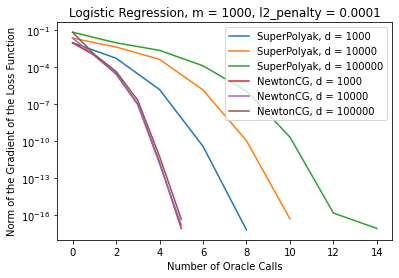

d	SuperPolyak time (s)	NewtonCG time (s)
-------------------------------------------------
1000	0.023495912551879883	0.05375099182128906
10000	0.38303589820861816	0.6963608264923096
100000	3.3524928092956543	4.931229829788208


In [4]:
# This cell compares newtoncg to SuperPolyak on the same problem as in the previous cell.
# It will run the code for
## m = 1000
## d in [1000, 10000, 100000]
## l2_penalty =.0001
# It will plot the number of oracle calls vs the norm of the gradient of the loss function.
# It will also print the time taken for each method to run for each problem size `d`.
## The time output will be in the form of a table.
## The first column is the problem size `d`.
## The second column is time taken by SuperPolyak.
## The third column is time taken by NewtonCG.
import problems
import torch
import time
import newtoncg
import SuperPolyak
import matplotlib.pyplot as plt
import util

# define m and l2_penalty
m = 1000
l2_penalty = .0001

# define the problem sizes
d_list = [1000, 10000, 100000]

# define a list to store the time taken by SuperPolyak
superpolyak_time = []

# define a list to store the time taken by NewtonCG
newtoncg_time = []

# define a list to store the number of oracle calls for SuperPolyak
superpolyak_oracle_calls = []

# define a list to store the number of oracle calls for NewtonCG
newtoncg_oracle_calls = []

# define a list to store the norm of the gradient of the loss function for SuperPolyak
superpolyak_grad_norm = []

# define a list to store the norm of the gradient of the loss function for NewtonCG
newtoncg_grad_norm = []

tol = 1e-16
init_distance = 1
# for each problem size, run SuperPolyak and NewtonCG
for d in d_list:
    # define the problem
    z = problems.LogisticRegressionProblem(m=m, d=d, l2_penalty=l2_penalty)
    # define the initial point
    init = z.initializer(init_distance)
    # define the parameter
    param = [init]
    # define the linear system solver
    linsys_solver = SuperPolyak.BundleLinearSystemSolver.QR
    # define the SuperPolyak optimizer
    superpolyak_optimizer = SuperPolyak.SuperPolyak(
        param, max_elts=2, eta_est=2, linsys_solver=linsys_solver
    )
    # define the SGD optimizer
    sgd_optimizer = torch.optim.SGD(param, lr=z.lr)
    loss_function = z.norm_grad()

    # define the superpolyak closure
    def superpolyak_closure():
        superpolyak_optimizer.zero_grad()
        loss = loss_function(init)
        loss.backward()
        return loss

    # define the sgd closure
    def sgd_closure():
        sgd_optimizer.zero_grad()
        loss = z.loss(init)
        loss.backward()
        return loss


    # define the oracle calls and loss list for SuperPolyak
    oracle_calls = [0]
    loss_list = [superpolyak_closure().item()]

    # start timer
    start = time.time()
    max_inner_iter = 100
    max_outer_iter = 100
    # start timer
    start = time.time()
    oracle_calls, loss_list = util.superpolyak_coupled_with_fallback(
        superpolyak_closure=superpolyak_closure,
        fallback_closure=sgd_closure,
        superpolyak_optimizer=superpolyak_optimizer,
        fallback_optimizer=sgd_optimizer,
        max_inner_iter=max_inner_iter,
        tol=tol,
        max_outer_iter=max_outer_iter,
        verbose=True,
    )
    # end timer
    end = time.time()

    # store the time taken by SuperPolyak
    superpolyak_time.append(end - start)

    # store the number of oracle calls for SuperPolyak
    superpolyak_oracle_calls.append(oracle_calls)

    # store the norm of the gradient of the loss function for SuperPolyak
    superpolyak_grad_norm.append(loss_list)

    # reinitialize the parameter
    init = z.initializer(init_distance)
    param = [init]
    # define the newton optimizer
    Newton_optimizer = newtoncg.NewtonCG(param)
    def grad_norm_closure():
        Newton_optimizer.zero_grad()
        loss = z.norm_grad()(init)
        # loss.backward()
        return loss
    # define the newton closure
    def Newton_closure(x):
        Newton_optimizer.zero_grad()
        loss = z.loss()(x)
        # loss.backward()
        return loss
    # define the oracle calls and loss list for NewtonCG
    oracle_calls_newton = [0]
    loss_list_newton = [grad_norm_closure().item()]
    # define the loss function, which is the norm of the gradient of the loss function
    # start timer
    max_oracle_calls = 10
    start = time.time()
    while (
        loss_list_newton[-1] > tol
        and oracle_calls_newton[-1] < max_oracle_calls
    ):
        Newton_optimizer.step(Newton_closure)
        oracle_calls_newton.append(1 + oracle_calls_newton[-1])
        loss_list_newton.append(grad_norm_closure().item())

    # end timer
    end = time.time()

    # store the time taken by NewtonCG
    newtoncg_time.append(end - start)

    # store the number of oracle calls for NewtonCG
    newtoncg_oracle_calls.append(oracle_calls_newton)

    # store the norm of the gradient of the loss function for NewtonCG
    newtoncg_grad_norm.append(loss_list_newton)

    print("d = {}, SuperPolyak time = {}, NewtonCG time = {}".format(d, superpolyak_time[-1], newtoncg_time[-1]))

# Now for each problem size, plot the number of oracle calls vs the norm of the gradient of the loss function.
## add a legend to the plot to indicate which method is which and which problem size is which.
## add a title to the plot to indicate the value of m and l2_penalty.
## add a label to the x-axis to indicate what it is.
## add a label to the y-axis to indicate what it is.


# for each problem size plot the number of oracle calls vs the norm of the gradient of the loss function for SuperPolyak
for d in d_list:
    plt.semilogy(superpolyak_oracle_calls[d_list.index(d)], superpolyak_grad_norm[d_list.index(d)], label="SuperPolyak, d = {}".format(d))

# for each problem size plot the number of oracle calls vs the norm of the gradient of the loss function for NewtonCG
for d in d_list:
    plt.semilogy(newtoncg_oracle_calls[d_list.index(d)], newtoncg_grad_norm[d_list.index(d)], label="NewtonCG, d = {}".format(d))

# add a legend to the plot to indicate which method is which and which problem size is which
plt.legend()
# move the legend to the top right of the plot
plt.legend(loc="upper right")
# add a title to the plot to indicate the value of m and l2_penalty and the fact that this is logistic regression
plt.title("Logistic Regression, m = {}, l2_penalty = {}".format(m, l2_penalty))
# add a label to the x-axis to indicate what it is
plt.xlabel("Number of Oracle Calls")
# add a label to the y-axis to indicate what it is
plt.ylabel("Norm of the Gradient of the Loss Function")
# show the plot
plt.show()

# now print a table of the number the time taken for each problem size for SuperPolyak and NewtonCG
print("d\tSuperPolyak time (s)\tNewtonCG time (s)")
# make sure the table is aligned
print("-------------------------------------------------")
# for each problem size print the time taken for SuperPolyak and NewtonCG
for d in d_list:
    print("{}\t{}\t{}".format(d, superpolyak_time[d_list.index(d)], newtoncg_time[d_list.index(d)]))
